The Canny edge detection algorithm is composed of 5 steps:

* Noise reduction
* Gradient calculation
* Non-Maximum suppresion
* Double threshold
* Edge Tracking by Hysteresis

## Noise Reduction

Since the mathematics involved behind the scene are mainly based on derivatives (step 2: Gradient calculation), edge detection results are highly sensitive to image noise.

One way to get rid of the noise on the image, is by applying Gaussian blur to smooth it. To do so, image convolution technique is applied with a Gaussian Kernel (3x3, 5x5, 7x7 etc…). The kernel size depends on the expected blurring effect. Basically, the smallest the kernel, the less visible is the blur. In our example, we will use a 5 by 5 Gaussian kernel.

The equation for a Gaussian filter kernel of size (2k+1)×(2k+1) is given by:

<img src = 'gaussian_kernel_equation.png'>

## Original Image

<img src = 'original_grey_image.jpg'>

## Gradient Calculation

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.

Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)

When the image is smoothed, the derivatives Ix and Iy w.r.t. x and y are calculated. It can be implemented by convolving I with Sobel kernels Kx and Ky, respectively:

<img src = 'sobel_kernel.png'>

Then, the magnitude G and the slope θ of the gradient are calculated as follow:

<img src = 'gradient_intensity.png'>

In [8]:
from scipy import ndimage
from scipy.ndimage.filters import convolve

from scipy import misc
import numpy as np
from PIL import Image

class cannyEdgeDetector:
    def __init__(self, imgs, sigma=1, kernel_size=5, weak_pixel=75, strong_pixel=255, lowthreshold=0.05, highthreshold=0.15):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.kernel_size = kernel_size
        self.lowThreshold = lowthreshold
        self.highThreshold = highthreshold
        return 
    
    def gaussian_kernel(self, size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g
    
    def sobel_filters(self, img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)
    

    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0


                except IndexError as e:
                    pass

        return Z

    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    def hysteresis(self, img):

        M, N = img.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass

        return img
    
    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filters(self.img_smoothed)
            self.nonMaxImg = self.non_max_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

<Figure size 1800x864 with 0 Axes>

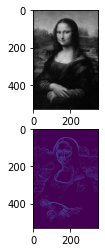

In [3]:
import numpy as np 
import os 
import cv2 
import matplotlib.pyplot as plt 


# defining the canny detector function 

# here weak_th and strong_th are thresholds for 
# double thresholding step 
def Canny_detector(img, weak_th = None, strong_th = None): 
	
	# conversion of image to grayscale 
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
	
	# Noise reduction step 
	img = cv2.GaussianBlur(img, (5, 5), 1.4) 
	
	# Calculating the gradients 
	gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3) 
	gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3) 
	
	# Conversion of Cartesian coordinates to polar 
	mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 
	
	# setting the minimum and maximum thresholds 
	# for double thresholding 
	mag_max = np.max(mag) 
	if not weak_th:weak_th = mag_max * 0.1
	if not strong_th:strong_th = mag_max * 0.5
	
	# getting the dimensions of the input image 
	height, width = img.shape 
	
	# Looping through every pixel of the grayscale 
	# image 
	for i_x in range(width): 
		for i_y in range(height): 
			
			grad_ang = ang[i_y, i_x] 
			grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang) 
			
			# selecting the neighbours of the target pixel 
			# according to the gradient direction 
			# In the x axis direction 
			if grad_ang<= 22.5: 
				neighb_1_x, neighb_1_y = i_x-1, i_y 
				neighb_2_x, neighb_2_y = i_x + 1, i_y 
			
			# top right (diagnol-1) direction 
			elif grad_ang>22.5 and grad_ang<=(22.5 + 45): 
				neighb_1_x, neighb_1_y = i_x-1, i_y-1
				neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
			
			# In y-axis direction 
			elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90): 
				neighb_1_x, neighb_1_y = i_x, i_y-1
				neighb_2_x, neighb_2_y = i_x, i_y + 1
			
			# top left (diagnol-2) direction 
			elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135): 
				neighb_1_x, neighb_1_y = i_x-1, i_y + 1
				neighb_2_x, neighb_2_y = i_x + 1, i_y-1
			
			# Now it restarts the cycle 
			elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180): 
				neighb_1_x, neighb_1_y = i_x-1, i_y 
				neighb_2_x, neighb_2_y = i_x + 1, i_y 
			
			# Non-maximum suppression step 
			if width>neighb_1_x>= 0 and height>neighb_1_y>= 0: 
				if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]: 
					mag[i_y, i_x]= 0
					continue

			if width>neighb_2_x>= 0 and height>neighb_2_y>= 0: 
				if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]: 
					mag[i_y, i_x]= 0

	weak_ids = np.zeros_like(img) 
	strong_ids = np.zeros_like(img)			 
	ids = np.zeros_like(img) 
	
	# double thresholding step 
	for i_x in range(width): 
		for i_y in range(height): 
			
			grad_mag = mag[i_y, i_x] 
			
			if grad_mag<weak_th: 
				mag[i_y, i_x]= 0
			elif strong_th>grad_mag>= weak_th: 
				ids[i_y, i_x]= 1
			else: 
				ids[i_y, i_x]= 2
	
	
	# finally returning the magnitude of 
	# gradients of edges 
	return mag 

frame = cv2.imread('original_grey_image.jpg') 

# calling the designed function for 
# finding edges 
canny_img = Canny_detector(frame) 

# Displaying the input and output image 
plt.figure(figsize=(25, 12)) 
f, plots = plt.subplots(2, 1) 
plots[0].imshow(frame)
plots[1].imshow(canny_img)

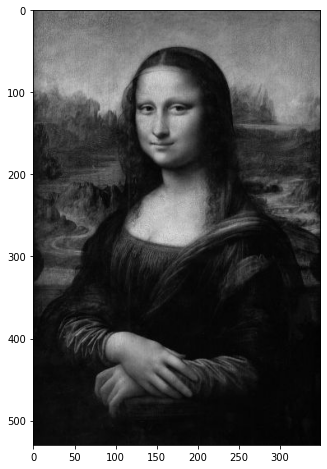

In [17]:
plt.figure(figsize = (10, 8))
plt.imshow(frame);

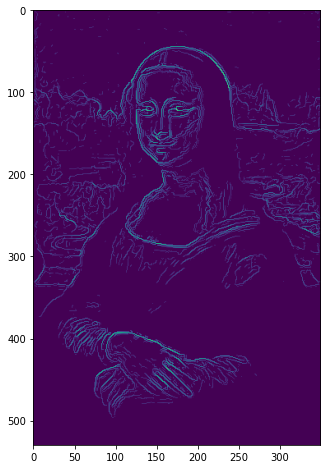

In [16]:
plt.figure(figsize = (10, 8))
plt.imshow(canny_img);